Takes csv file created by data notebook to drop instances, drop features if too much missing, checks and fixes formatting

In [230]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer

from load import read_csv

In [231]:
path = './Data/bt.csv'

In [232]:
df = read_csv(path)
print(len(df))
pd.set_option('display.max_columns', None)
df.head()

47333


,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,T_BEST,N_BEST,M_BEST,STAGE_BEST,STAGE_BEST_SYSTEM,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,SCREENINGSTATUSFULL_CODE,ER_STATUS,ER_SCORE,PR_STATUS,PR_SCORE,HER2_STATUS,CANCERCAREPLANINTENT,PERFORMANCESTATUS,CNS,ACE27,GLEASON_PRIMARY,GLEASON_SECONDARY,GLEASON_TERTIARY,GLEASON_COMBINED,DATE_FIRST_SURGERY,LATERALITY,QUINTILE_2015,TUMOUR_COUNT,ETHNICITY,DEATHCAUSECODE_1A,DEATHCAUSECODE_1B,DEATHCAUSECODE_1C,DEATHCAUSECODE_2,DEATHCAUSECODE_UNDERLYING,DEATHLOCATIONCODE,NEWVITALSTATUS,VITALSTATUSDATE,MERGED_PATIENT_ID,SACT,MERGED_TUMOUR_ID,REGIMEN_COUNT,DATE_FIRST_REGIMEN,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,HIGHEST_CYCLE
0,10614165,10501771,2017-01-16,C719,C71,9440.0,3,NaN,NaN,NaN,U,NaN,G4,69,1,L0401,810501771,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-01-16,R,4,2,A,NaN,NaN,NaN,NaN,NaN,NaN,A,2019-02-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10614166,10501772,2015-11-10,C712,C71,9440.0,3,NaN,NaN,NaN,U,NaN,G4,88,1,L1001,810501772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-10,R,1 - least deprived,2,A,"C719,D432",NaN,NaN,NaN,C719,NaN,D,2015-11-27,10501772.0,True,10002483.0,5.0,2015-12-23,False,False,1.755,71.75,3.0
2,10614166,10501772,2015-11-10,C712,C71,9440.0,3,NaN,NaN,NaN,U,NaN,G4,88,1,L1001,810501772,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9,NaN,NaN,NaN,NaN,NaN,NaN,2015-11-10,R,1 - least deprived,2,A,"C719,D432",NaN,NaN,NaN,C719,NaN,D,2015-11-27,10501772.0,True,10004939.0,5.0,2015-12-23,False,False,1.755,71.75,3.0
3,10614174,10501888,2017-04-27,C713,C71,9401.0,3,NaN,NaN,NaN,U,NaN,G4,79,1,L1001,810501888,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2017-04-27,R,2,2,A,G231,"I739,N390",NaN,"I489,I518,E149",I251,4,D,2018-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10614177,10501946,2016-12-23,C711,C71,9440.0,3,NaN,NaN,NaN,U,NaN,GX,79,2,L1001,810501946,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,R,2,2,NaN,C719,NaN,NaN,"I259,E119",C61,NaN,D,2018-02-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [233]:
# df.SITE_ICD10_O2_3CHAR.value_counts()
# df['Reconstructed_3CHAR'] = df['SITE_ICD10_O2'].str[0:3]
# df['Match'] = df['Reconstructed_3CHAR'].isin(df['SITE_ICD10_O2_3CHAR'])
# df['Match'].value_counts()


Drop low height:  1298
Dropped:  1298


array([[<AxesSubplot:title={'center':'NORMALISED_HEIGHT'}>]], dtype=object)

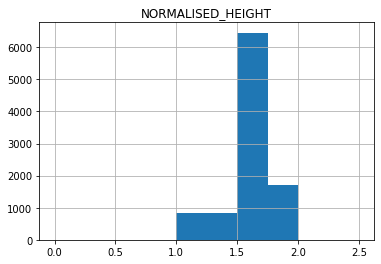

In [234]:
threshold = 1.0

print('Drop low height: ',(df.NORMALISED_HEIGHT < threshold).sum())
len_before = len(df)
df = df.drop(df[df.NORMALISED_HEIGHT < threshold].index)
len_after = len(df)
print('Dropped: ', len_before - len_after)
df.hist(column='NORMALISED_HEIGHT',bins=[0,0.25,0.5,0.75,1.0,1.25,1.5,1.75,2.0,2.25,2.5])


Drop low height:  1950
Dropped:  1950


array([[<AxesSubplot:title={'center':'NORMALISED_WEIGHT'}>]], dtype=object)

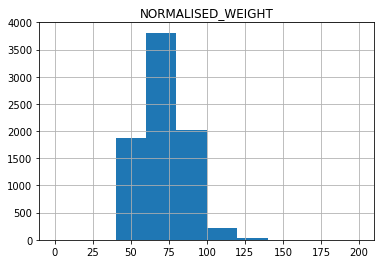

In [235]:
threshold = 40

print('Drop low height: ',(df.NORMALISED_WEIGHT < threshold).sum())
len_before = len(df)
df = df.drop(df[df.NORMALISED_WEIGHT < threshold].index)
len_after = len(df)
print('Dropped: ', len_before - len_after)
df.hist(column='NORMALISED_WEIGHT',bins=[0,20,40,60,80,100,120,140,160,180,200])

In [236]:
vital_alive = df[(df.NEWVITALSTATUS == 'A')] 
vital_dead = df[(df.NEWVITALSTATUS == 'D')]
vital_censored = df[(df.NEWVITALSTATUS == 'X')]
no_death = df[(df.DEATHCAUSECODE_1A.isnull()) &
                (df.DEATHCAUSECODE_1B.isnull()) & 
                (df.DEATHCAUSECODE_1C.isnull()) &
                (df.DEATHCAUSECODE_2.isnull()) &
                (df.DEATHCAUSECODE_UNDERLYING.isnull()) &
                (df.DEATHLOCATIONCODE.isnull())]  
death = df[~df.index.isin(no_death.index)]

alive_but_death = vital_alive[vital_alive.index.isin(death.index)]
dead_but_no_death = vital_dead[vital_dead.index.isin(no_death.index)]
censored_but_death = vital_censored[vital_censored.index.isin(death.index)]

print("".ljust(20), "Death".ljust(10), "No death".ljust(10), "Total")
print("Alive".ljust(20), str(len(alive_but_death)).ljust(10), str(len(vital_alive)-len(alive_but_death)).ljust(10), len(vital_alive))
print("Dead".ljust(20), str(len(vital_dead)-len(dead_but_no_death)).ljust(10), str(len(dead_but_no_death)).ljust(10), len(vital_dead))
print("Censored".ljust(20), str(len(censored_but_death)).ljust(10), str(len(vital_censored)-len(censored_but_death)).ljust(10), len(vital_censored))


                     Death      No death   Total
Alive                8118       16471      24589
Dead                 13635      5781       19416
Censored             30         50         80


In [237]:
threshold = 0.15
thresh = round(threshold * len(df))
print(len(df.columns))
print("Feature".ljust(30), "NaNs".ljust(10), "Pct".ljust(10), "Drop?")
for k, v in df.isna().sum(axis = 0).items():
    print(k.ljust(30), str(v).ljust(10), "{:.0%}".format(v/len(df)).ljust(10), v > len(df) - thresh)

54
Feature                        NaNs       Pct        Drop?
TUMOURID                       0          0%         False
PATIENTID                      0          0%         False
DIAGNOSISDATEBEST              0          0%         False
SITE_ICD10_O2                  13         0%         False
SITE_ICD10_O2_3CHAR            7          0%         False
MORPH_ICD10_O2                 21         0%         False
BEHAVIOUR_ICD10_O2             22         0%         False
T_BEST                         43431      99%        True
N_BEST                         43484      99%        True
M_BEST                         43394      98%        True
STAGE_BEST                     0          0%         False
STAGE_BEST_SYSTEM              40499      92%        True
GRADE                          1674       4%         False
AGE                            0          0%         False
SEX                            0          0%         False
CREG_CODE                      0          0%         Fals

In [238]:

df = df.dropna(axis=1, thresh=thresh)
df = df.drop(columns=['DEATHCAUSECODE_1A','DEATHCAUSECODE_UNDERLYING','DEATHLOCATIONCODE'])
df = df.drop(columns=['CANCERCAREPLANINTENT','PERFORMANCESTATUS'])
df = df.drop(columns=['MERGED_PATIENT_ID','MERGED_TUMOUR_ID'])

print(len(df.columns))


28


In [239]:
print("Feature".ljust(30), "NaNs".ljust(10), "Percentage of all")
for k, v in df.isna().sum(axis = 0).items():
    print(k.ljust(30), str(v).ljust(10), "{:.0%}".format(v/len(df)))

Feature                        NaNs       Percentage of all
TUMOURID                       0          0%
PATIENTID                      0          0%
DIAGNOSISDATEBEST              0          0%
SITE_ICD10_O2                  13         0%
SITE_ICD10_O2_3CHAR            7          0%
MORPH_ICD10_O2                 21         0%
BEHAVIOUR_ICD10_O2             22         0%
STAGE_BEST                     0          0%
GRADE                          1674       4%
AGE                            0          0%
SEX                            0          0%
CREG_CODE                      0          0%
LINKNUMBER                     0          0%
DATE_FIRST_SURGERY             18120      41%
LATERALITY                     0          0%
QUINTILE_2015                  0          0%
TUMOUR_COUNT                   0          0%
ETHNICITY                      1352       3%
NEWVITALSTATUS                 0          0%
VITALSTATUSDATE                0          0%
SACT                           33762   

In [240]:
df['SITE_ICD10_O2_3CHAR'] = df['SITE_ICD10_O2_3CHAR'].fillna(df['SITE_ICD10_O2'].str[0:3])
df = df.drop(columns=['SITE_ICD10_O2'])

In [243]:
column = 'BEHAVIOUR_ICD10_O2'
markers = ['X']
target = '1'

print(set(df[column]))
df[column], replaced  = replace(df, column, markers, target)
print(set(df[column]))
print(f'Replaced: {replaced}')

df[column] = df[column].astype(float)
print(f'{column} all ints: ',(df[column].fillna(-9999) % 1  == 0).all())

df[column] = mean_impute(df, column).astype(int)
set(df[column])

{nan, '1.0', '2.0', '1', '3.0', '3', '9', '6.0', '5', '6', '0.0', 'X', '0', '2'}
{nan, '1.0', '2.0', '1', '3.0', '3', '9', '6.0', '5', '6', '0.0', '0', '2'}
Replaced: 11
BEHAVIOUR_ICD10_O2 all ints:  True


{0, 1, 2, 3, 5, 6, 9}

In [244]:
column = 'MORPH_ICD10_O2'
print(f'{column} all ints: ',(df[column].fillna(-9999) % 1  == 0).all())
df[column] = mean_impute(df, column).astype(int)
# set(df[column])

MORPH_ICD10_O2 all ints:  True


In [245]:
column = 'STAGE_BEST'
print(df[column].value_counts())

keep = False
if keep:
    print(set(df[column]))
    df[column] = df[column].replace({'U' : '?'})
    print(set(df[column]))

    values = list(set(df[column]))
    replace_values = []

    for v in values:
        std_value = ''
        for ch in v:
            # print(ch, std_value)
            num = ord(ch) - 48
            if not ch.isdigit():
                num =  num + 48 - 64 
            std_value += str(num)
        for _ in range(len(std_value), 3): 
            std_value += '0'
        replace_values.append(std_value)

    print(replace_values)

    replace_dict = dict(zip(values, replace_values))

    df[column] = df[column].replace(replace_dict)
    print(set(df[column]))
else:
    df.drop(columns=column)


U      43202
?        372
4         90
1         85
3         63
0         48
2         48
1A        40
3A        21
1A1       16
2B        16
1B        15
4A        14
4B        13
2A        12
3B        10
1A2        7
3C         4
2C         3
1E         2
1B1        1
0A         1
4C         1
2A1        1
Name: STAGE_BEST, dtype: int64


In [246]:
column = 'GRADE'
target ='GX'

print(set(df[column]))
replaced = df[column].isna().sum()
df[column] = df[column].fillna(target)
print(set(df[column]))
print(f'Replaced: {replaced}')


{nan, 'GX', 'G4', 'G1', 'G2', 'G3'}
{'GX', 'G4', 'G1', 'G2', 'G3'}
Replaced: 1674


In [247]:
df['DATE_FIRST_SURGERY'] = pd.to_datetime(df['DATE_FIRST_SURGERY'])
df['DIAGNOSISDATEBEST'] = pd.to_datetime(df['DIAGNOSISDATEBEST'])

df['DAYS_TO_FIRST_SURGERY'] = (df['DATE_FIRST_SURGERY'] - df['DIAGNOSISDATEBEST']).dt.days.clip(0)

column = 'DAYS_TO_FIRST_SURGERY'
df[column] = mean_impute(df, column).astype(int)
df = df.drop(columns='DATE_FIRST_SURGERY')


In [248]:
df['LATERALITY'].value_counts(dropna=False)


9    22265
R    10696
L    10385
M      444
B      295
Name: LATERALITY, dtype: int64

In [249]:
# 1 - least, 5 - most deprived
df['QUINTILE_2015'] = df['QUINTILE_2015'].replace({'1 - least deprived' : 1, '5 - most deprived': 5})
df['QUINTILE_2015'].value_counts(dropna=False)

2    9810
1    9752
3    9210
4    7873
5    7440
Name: QUINTILE_2015, dtype: int64

In [250]:
# low concentration of non-white people
df['ETHNICITY'].value_counts(dropna=False)
replace_dict = {'A' : 'W', 'B' : 'W', 'C' : 'W',
                'D' : 'M', 'E' : 'M', 'F' : 'M', 'G' : 'M',
                'H' : 'A', 'J' : 'A', 'K' : 'A', 'L' : 'A',
                'M' : 'B', 'N' : 'B', 'P' : 'B',
                'R' : 'C',
                'S' : 'O',
                'X' : 'U', 'Z' : 'U', '0' : 'U', '8' : 'U'}
df['ETHNICITY'] = df['ETHNICITY'].replace(replace_dict)
df['ETHNICITY'].value_counts(dropna=False)
df['ETHNICITY'] = df['ETHNICITY'].fillna('U')
df['ETHNICITY'].value_counts(dropna=False)



W    38005
U     3121
A     1335
B      724
O      573
M      240
C       87
Name: ETHNICITY, dtype: int64

In [251]:
df['VITALSTATUSDATE'] = pd.to_datetime(df['VITALSTATUSDATE'])
df['DAYS_SINCE_DIAGNOSIS'] = (df['VITALSTATUSDATE'] - df['DIAGNOSISDATEBEST']).dt.days
df = df.drop(columns = 'VITALSTATUSDATE')
(df['DAYS_SINCE_DIAGNOSIS'] < 0).sum()

0

In [252]:
df['DATE_FIRST_REGIMEN'] = pd.to_datetime(df['DATE_FIRST_REGIMEN'])
df['DAYS_TO_FIRST_REGIMEN'] = (df['DATE_FIRST_REGIMEN'] - df['DIAGNOSISDATEBEST']).dt.days
print("Drop less than 0 days: ",len(df[df.DAYS_TO_FIRST_REGIMEN < 0]))
df = df.drop(df[df.DAYS_TO_FIRST_REGIMEN < 0].index)
df = df.drop(columns = 'DATE_FIRST_REGIMEN')

Drop less than 0 days:  3093


In [253]:
df['SACT'] = df['SACT'].fillna(False)

# df.loc[df.REGIMEN_COUNT.isna(), df.CLINICAL_TRIAL_INDICATOR.isna(), df.CHEMO_RADIATION_INDICATOR.isna(), df.NORMALISED_HEIGHT.isna(), df.NORMALISED_WEIGHT.isna(), df.HIGHEST_CYCLE.isna(), 'SACT'] = False

# df.loc[df['REGIMEN_COUNT'].isna(), 'SACT'] = False
df.loc[df.REGIMEN_COUNT.isna() & 
        df.CLINICAL_TRIAL_INDICATOR.isna() & 
        df.CHEMO_RADIATION_INDICATOR.isna() & 
        df.CHEMO_RADIATION_INDICATOR.isna() & 
        df.NORMALISED_HEIGHT.isna() & 
        df.NORMALISED_WEIGHT.isna() & 
        df.HIGHEST_CYCLE.isna(), 
        'SACT'] = False

df[(df['SACT'] == True) & (df['REGIMEN_COUNT'].isna())]

,TUMOURID,PATIENTID,DIAGNOSISDATEBEST,SITE_ICD10_O2_3CHAR,MORPH_ICD10_O2,BEHAVIOUR_ICD10_O2,STAGE_BEST,GRADE,AGE,SEX,CREG_CODE,LINKNUMBER,LATERALITY,QUINTILE_2015,TUMOUR_COUNT,ETHNICITY,NEWVITALSTATUS,SACT,REGIMEN_COUNT,CLINICAL_TRIAL_INDICATOR,CHEMO_RADIATION_INDICATOR,NORMALISED_HEIGHT,NORMALISED_WEIGHT,HIGHEST_CYCLE,DAYS_TO_FIRST_SURGERY,DAYS_SINCE_DIAGNOSIS,DAYS_TO_FIRST_REGIMEN


In [254]:
df['REGIMEN_COUNT'] = df['REGIMEN_COUNT'].fillna(0)
df['REGIMEN_COUNT'] = df['REGIMEN_COUNT'].astype(int)

df.NORMALISED_HEIGHT = df.NORMALISED_HEIGHT.fillna(0)

df.NORMALISED_WEIGHT = df.NORMALISED_WEIGHT.fillna(0)

df.HIGHEST_CYCLE = df.HIGHEST_CYCLE.fillna(0)
df.HIGHEST_CYCLE = df.HIGHEST_CYCLE.astype(int)

df.DAYS_TO_FIRST_REGIMEN = df.DAYS_TO_FIRST_REGIMEN.fillna(0)
df.DAYS_TO_FIRST_REGIMEN = df.DAYS_TO_FIRST_REGIMEN.astype(int)

In [255]:
df['CLINICAL_TRIAL_INDICATOR'] = df['CLINICAL_TRIAL_INDICATOR'].fillna(False)
df['CHEMO_RADIATION_INDICATOR'] = df['CHEMO_RADIATION_INDICATOR'].fillna(False)

In [256]:
df = df.drop(columns = ['TUMOURID',	'PATIENTID'	,'DIAGNOSISDATEBEST','LINKNUMBER'])

In [257]:
df.to_csv('./Data/bt-impute.csv', index=False)

In [258]:
print("Feature".ljust(30), "NaNs".ljust(10), "Percentage of all")
for k, v in df.isna().sum(axis = 0).items():
    print(k.ljust(30), str(v).ljust(10), "{:.0%}".format(v/len(df)))

Feature                        NaNs       Percentage of all
SITE_ICD10_O2_3CHAR            0          0%
MORPH_ICD10_O2                 0          0%
BEHAVIOUR_ICD10_O2             0          0%
STAGE_BEST                     0          0%
GRADE                          0          0%
AGE                            0          0%
SEX                            0          0%
CREG_CODE                      0          0%
LATERALITY                     0          0%
QUINTILE_2015                  0          0%
TUMOUR_COUNT                   0          0%
ETHNICITY                      0          0%
NEWVITALSTATUS                 0          0%
SACT                           0          0%
REGIMEN_COUNT                  0          0%
CLINICAL_TRIAL_INDICATOR       0          0%
CHEMO_RADIATION_INDICATOR      0          0%
NORMALISED_HEIGHT              0          0%
NORMALISED_WEIGHT              0          0%
HIGHEST_CYCLE                  0          0%
DAYS_TO_FIRST_SURGERY          0        